# Import

In [1]:
import os
import numpy as np
import cv2
from glob import glob 
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.layers import Cropping2D

In [2]:
# print(tf.__version__)
!nvidia-smi

Wed May  3 10:10:42 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.68                 Driver Version: 531.68       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 L...  WDDM | 00000000:01:00.0 Off |                  N/A |
| N/A   48C    P0               22W /  N/A|      0MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Seeding

In [3]:
os.environ["PYTHONHASHEED"] = str(42)
np.random.seed(42)
tf.random.set_seed(42)

# Hyperparameters

In [4]:
batch_size = 1
lr = 1e-4 ## 0.0004
epochs = 100
height = 576
width = 928

# Path

In [5]:
dataset_path = os.path.join("dataset", "Model")

files_dir = os.path.join("files", "saves")
model_file = os.path.join(files_dir, "unet.h5")
log_file = os.path.join(files_dir, "log.csv")

# Creating folder

In [6]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
    else:
        print("Path exits")

# Building U-NET

Conv Block

In [7]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x) 
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x


Encoder Block

In [8]:
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2,2))(x)
    
    return x, p

Decoder Block

In [9]:
def decoder_block(inputs, skip, num_filters):
    x = Conv2DTranspose(num_filters, (2,2), strides = 2, padding = "same")(inputs)
    x = Concatenate()([x, skip])
    x = conv_block(x, num_filters)
    
    
    return x

U-NET

In [10]:
def build_unet(input_shape): 
    inputs = Input(input_shape)
    

    """ Encoder """
    s1, p1 = encoder_block(inputs, 64) 
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    #s4, p4 = encoder_block(p3, 512)
    
    
    """Bridge""" 
    #b1 = conv_block (p4, 1024)
    b1 = conv_block (p3, 512)

    
    """ Decoder """
#     d1 = decoder_block(b1, s4, 512)
#     d2 = decoder_block(d1, s3, 256)
#     d3 = decoder_block(d2, s2, 128)
#     d4 = decoder_block(d3, s1, 64)
    d1 = decoder_block(b1, s3, 256)
    d2 = decoder_block(d1, s2, 128)
    d3 = decoder_block(d2, s1, 64)
    
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d3)#d4

    model = Model(inputs, outputs, name="UNET")

    return model


# Dataset Pipeline 

Loading the training and validation dataset

In [11]:
def load_data(path):
    train_x = sorted(glob(os.path.join(path, "train", "images", "*")))
    train_y = sorted(glob(os.path.join(path, "train", "masks", "*")))
    
    valid_x = sorted(glob(os.path.join(path, "valid", "images", "*")))
    valid_y = sorted(glob(os.path.join(path, "valid", "masks", "*")))
    
    return (train_x, train_y), (valid_x, valid_y)

Reading Images

In [12]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = x/255.0
    return x

Reading Masks

In [13]:
def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = x/255.0
    x = np.expand_dims(x, axis= -1)
    return x

tf.data pipeline

In [14]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y
    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([height,width, 3])
    y.set_shape([height,width, 1])
    
    return x, y

In [15]:
def tf_dataset(x, y, batch=batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

# Training

In [16]:
(train_x, train_y), (valid_x, valid_y) = load_data(dataset_path)
print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

Train: 700 - 700
Valid: 40 - 40


In [17]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

In [18]:
# train_dataset

In [19]:
# for x, y in train_dataset:
#     print(x.shape, y.shape)

In [20]:
# for x, y in valid_dataset:
#     print(x.shape, y.shape)

In [21]:
input_shape = (height, width, 3)
model = build_unet(input_shape)

In [22]:
# model.summary()

In [23]:
opt = tf.keras.optimizers.Adam(lr)  # 0.85
#opt = tf.keras.optimizers.SGD(lr)  # 0.77
# opt = tf.keras.optimizers.RMSprop(lr) #0.83 and memory error
# opt = tf.keras.optimizers.Adagrad(lr) #0.77
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["acc"])

In [24]:
callbacks = [
    ModelCheckpoint(model_file, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience = 4),
    CSVLogger(log_file),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
]

In [25]:
model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/100
700/700 [==============================] - ETA: 0s - loss: 0.3346 - acc: 0.8467
Epoch 1: val_loss improved from inf to 0.40076, saving model to files\saves\unet.h5
700/700 [==============================] - 373s 480ms/step - loss: 0.3346 - acc: 0.8467 - val_loss: 0.4008 - val_acc: 0.8031 - lr: 1.0000e-04
Epoch 2/100
700/700 [==============================] - ETA: 0s - loss: 0.2727 - acc: 0.8837
Epoch 2: val_loss improved from 0.40076 to 0.37871, saving model to files\saves\unet.h5
700/700 [==============================] - 340s 486ms/step - loss: 0.2727 - acc: 0.8837 - val_loss: 0.3787 - val_acc: 0.8246 - lr: 1.0000e-04
Epoch 3/100
700/700 [==============================] - ETA: 0s - loss: 0.2495 - acc: 0.8936
Epoch 3: val_loss improved from 0.37871 to 0.33546, saving model to files\saves\unet.h5
700/700 [==============================] - 339s 485ms/step - loss: 0.2495 - acc: 0.8936 - val_loss: 0.3355 - val_acc: 0.8419 - lr: 1.0000e-04
Epoch 4/100
700/700 [=================

Epoch 28/100
700/700 [==============================] - ETA: 0s - loss: 0.1668 - acc: 0.9282
Epoch 28: val_loss did not improve from 0.27350
700/700 [==============================] - 342s 489ms/step - loss: 0.1668 - acc: 0.9282 - val_loss: 0.2751 - val_acc: 0.8995 - lr: 1.0000e-07
Epoch 29/100
700/700 [==============================] - ETA: 0s - loss: 0.1665 - acc: 0.9283
Epoch 29: val_loss did not improve from 0.27350
700/700 [==============================] - 342s 488ms/step - loss: 0.1665 - acc: 0.9283 - val_loss: 0.2751 - val_acc: 0.8994 - lr: 1.0000e-07
Epoch 30/100
700/700 [==============================] - ETA: 0s - loss: 0.1664 - acc: 0.9283
Epoch 30: val_loss did not improve from 0.27350
700/700 [==============================] - 340s 486ms/step - loss: 0.1664 - acc: 0.9283 - val_loss: 0.2753 - val_acc: 0.8993 - lr: 1.0000e-07
Epoch 31/100
700/700 [==============================] - ETA: 0s - loss: 0.1662 - acc: 0.9284
Epoch 31: val_loss did not improve from 0.27350
700/700 [=

In [26]:
!nvidia-smi

Wed May  3 14:11:12 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.68                 Driver Version: 531.68       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 L...  WDDM | 00000000:01:00.0 Off |                  N/A |
| N/A   84C    P0               50W /  N/A|   4618MiB /  6144MiB |     64%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Predict Mask

# Import

In [32]:
import os 
import time
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import tensorflow as tf

# Seeding

In [33]:
os.environ["PYTHONHASHEED"] = str(42)
np.random.seed(42)
tf.random.set_seed(42)

# Hyperparameters

In [34]:
height = 576
width = 928

# Path

In [35]:
dataset_path = os.path.join("dataset", "Model", "test")

save_path = "pre\\mask"
model_path = r"files\\saves\\unet.h5"

In [36]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [37]:
create_dir(save_path)

In [38]:
# Load Model

In [39]:
model = tf.keras.models.load_model(model_path)

In [40]:
# model.summary()

In [41]:
test_x = sorted(glob(os.path.join(dataset_path, "images", "*")))
print(f"Test Images: {len(test_x)}")

Test Images: 10


In [42]:
# test_x[0]

In [43]:
# Predict Mask

In [69]:
time_taken = []
for x in tqdm(test_x):
    name = x.split("\\")[-1]
    print(name)
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = x/255.0
#     print(x.shape)
    x = np.expand_dims(x, axis=0)
    
    start_time = time.time()
    p = model.predict(x)
    total_time = time.time() - start_time
    time_taken.append(total_time)
    p = p > 0.3
    p = p*255
    
    cv2.imwrite(os.path.join(save_path, name), p[0])

    
    
    

  0%|          | 0/10 [00:00<?, ?it/s]

(251).jpeg
1/1 [==============================] - 0s 24ms/step


 10%|█         | 1/10 [00:00<00:04,  2.14it/s]

(252).jpeg
1/1 [==============================] - 0s 21ms/step


 20%|██        | 2/10 [00:00<00:02,  2.99it/s]

(253).jpeg
1/1 [==============================] - 0s 20ms/step


 30%|███       | 3/10 [00:00<00:02,  3.45it/s]

(254).jpeg
1/1 [==============================] - 0s 19ms/step


 40%|████      | 4/10 [00:01<00:01,  3.71it/s]

(255).jpeg
1/1 [==============================] - 0s 19ms/step


 50%|█████     | 5/10 [00:01<00:01,  3.86it/s]

(256).jpeg
1/1 [==============================] - 0s 22ms/step


 60%|██████    | 6/10 [00:01<00:01,  3.95it/s]

(257).jpeg
1/1 [==============================] - 0s 20ms/step


 70%|███████   | 7/10 [00:01<00:00,  4.01it/s]

(258).jpeg
1/1 [==============================] - 0s 21ms/step


 80%|████████  | 8/10 [00:02<00:00,  4.05it/s]

(259).jpeg
1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 9/10 [00:02<00:00,  4.07it/s]

(260).jpeg
1/1 [==============================] - 0s 22ms/step


100%|██████████| 10/10 [00:02<00:00,  3.80it/s]


In [70]:
mean_time = np.mean(time_taken)
mean_fps = 1/mean_time

In [71]:
print(f"Mean Time: {mean_time: 1.5f} - Mean FPS: {mean_fps:2.5f}")

Mean Time:  0.25032 - Mean FPS: 3.99489


# Testing the model

In [13]:
import tensorflow as tf
import cv2
import numpy as np

# Load pre-trained U-Net model

# 1st Model
# model = tf.keras.models.load_model(r"C:\Users\bishn\Desktop\chest_xray\Code\files\saves\85 percent with adam\unet.h5")
# 2nd Model
# model = tf.keras.models.load_model(r"C:\Users\bishn\Desktop\X-ray 2nd\files\saves\unet.h5")
# 3rd Model
model = tf.keras.models.load_model(r"C:\Users\bishn\Desktop\chest_xray\Code\files\saves\unet.h5")

1/1 [==============================] - 0s 23ms/step


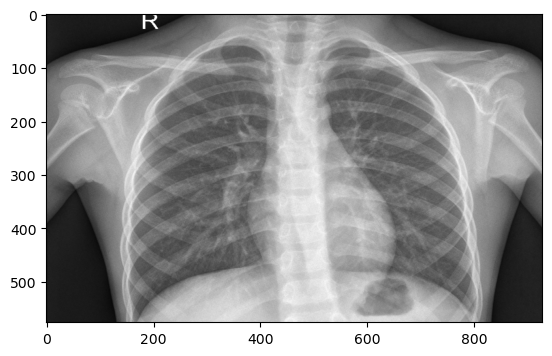

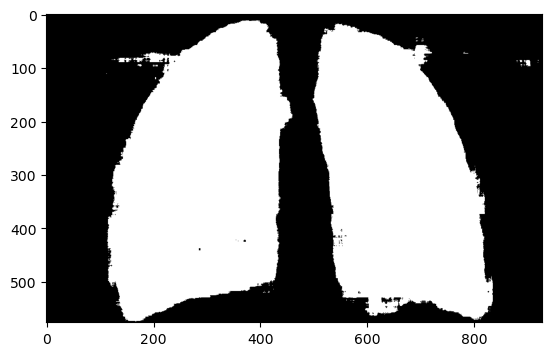

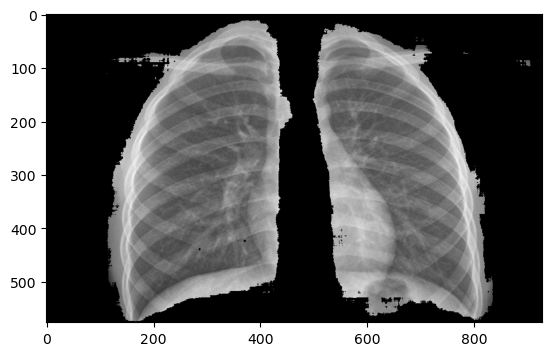

In [20]:
# Load test image

# Normal Image
test_image = tf.keras.preprocessing.image.load_img(r"C:\Users\bishn\Desktop\Code\input.jpeg", target_size=(576,928))

# Pneumonia Image
# test_image = tf.keras.preprocessing.image.load_img(r"C:\Users\bishn\Desktop\Code\CL_pin.jpeg", target_size=(576,928))


X_ray_image = test_image
test_image = tf.keras.preprocessing.image.img_to_array(test_image)
test_image = test_image / 255.0  # Normalize image

# Predict segmentation mask
test_image = tf.expand_dims(test_image, axis=0)  # Add batch dimension
segmentation_mask = model.predict(test_image)

segmentation_mask = segmentation_mask > 0.2
segmentation_mask = segmentation_mask*255

import matplotlib.pyplot as plt

plt.imshow(X_ray_image)
plt.show()

plt.imshow(segmentation_mask[0], cmap='gray')
plt.show()

masked_image = test_image[0] * segmentation_mask[0] / 255.0



plt.imshow(masked_image)
plt.show()


from PIL import Image
import numpy as np

# convert tensor to numpy array and make sure its values are in the range of 0-255
masked_image_np = np.array(masked_image)
masked_image_np = (masked_image_np * 255).astype(np.uint8)

# convert numpy array to PIL Image
masked_image_pil = Image.fromarray(masked_image_np)

# save the image
masked_image_pil.save(r'C:\Users\bishn\Desktop\Website code\Proccesing_image\prediction_1_output.png')
